# American Option Pricing via Finite Difference Methods


The objective of this project is to numerically solve the Black–Scholes partial differential equation associated with the valuation of an American option using finite difference methods.  

Unlike a European option, an American option may be exercised at any time prior to maturity, which leads to a nonlinear obstacle problem formulated as a variational inequality.

Several numerical schemes are considered to discretize this problem:

- Explicit Euler scheme (EE),
- Implicit schemes (CN and IE),
- Higher–order schemes of BDF type.

The resulting discrete obstacle problems are solved using adapted iterative methods (splitting methods, PSOR, semi-smooth Newton).

The price $v(t,s)$ is the solution of the variational inequality

$$
\min \left(
\frac{\partial v}{\partial t}
- \frac{1}{2} \sigma^2 s^2 \frac{\partial^2 v}{\partial s^2}
- r s \frac{\partial v}{\partial s}
+ r v,
\; v - \varphi(s)
\right) = 0,
\quad (t,s) \in (0,T) \times \Omega,
$$

where $\Omega = (S_{\min}, S_{\max})$. Standard boundary conditions and the initial condition are imposed in the usual way.

Two payoff functions are considered:

1. The American put payoff
$$
\varphi_1(s) = (K - s)^+,
$$

2. A discontinuous function
$$
\varphi_2(s) =
\begin{cases}
K, & \text{if } \frac{K}{2} \le s \le K, \\
0, & \text{otherwise},
\end{cases}
$$

used to test the robustness of the numerical schemes when the initial data contains a discontinuity.

The financial parameters used in the study are

$$
K = 100, \quad T = 1, \quad \sigma = 0.3, \quad r = 0.1,
$$

and the spatial computational domain is chosen as

$$
s \in [S_{\min}, S_{\max}] = [50, 250].
$$

Finally, particular attention is given to the numerical approximation of the quantity

$$
\bar{v} = v(T, S_{\text{val}}),
\quad S_{\text{val}} = 90,
$$

as well as to the analysis of convergence and computational cost of the different schemes as the time and space steps tend to zero.

In [1]:
import time
import numpy as np
import numpy.linalg as lng

# --------- Parameters ----------
r = 0.1
sigma = 0.3
K = 100.0
T = 1.0
Smin = 50.0
Smax = 250.0

# --------- Payoffs: payoff = 1 or 2 ----------
def phi(s, payoff=1):
    s = np.asarray(s, dtype=float)
    if payoff == 1:
        # American put
        return np.maximum(K - s, 0.0)
    elif payoff == 2:
        # Discontinuous payoff
        return K * ((s >= K/2.0) & (s <= K)).astype(float)
    else:
        raise ValueError("payoff must be 1 or 2")

def uleft(tn, payoff=1):
    if payoff == 1:
        return K - Smin
    elif payoff == 2:
        return 0.0
    else:
        raise ValueError("payoff must be 1 or 2")

def uright(tn):
    return 0.0


def PSOR(B, b, g, I, x0=None, eta=1e-6, kmax=1000, verbose=False, acceleration=1):

    start = time.time()

    if x0 is None:
        x = np.zeros_like(g)
    else:
        x = np.asarray(x0).reshape(-1).copy()

    b = np.asarray(b).reshape(-1)
    g = np.asarray(g).reshape(-1)
    x = np.asarray(x).reshape(-1)

    k = 0
    while k < kmax:
        xold = x.copy()

        for i in range(I):

            # Compute the Gauss-Seidel residual excluding the diagonal term
            s = np.dot(B[i, :], x) - B[i, i] * x[i]

            if acceleration == 1:
                # Standard Gauss-Seidel step
                x[i] = (b[i] - s) / B[i, i]
            else:
                # Relaxed (over-relaxed) Gauss-Seidel step
                w = acceleration
                x_gs = (b[i] - s) / B[i, i]
                x[i] = (1 - w) * x[i] + w * x_gs

            # Projection onto the constraint
            x[i] = max(x[i], g[i])

        k += 1

        err1 = lng.norm(x - xold)
        err2 = lng.norm(np.minimum(B @ x - b, x - g))

        # if verbose:
        #     print("k=%3i, |x-xold|=%10.6f, |min(Bx-b, x-g)|=%10.6f" % (k, err1, err2))

        if err1 < eta:
            break

        if k == kmax and verbose:
            print("PSOR did not converge after %i iterations" % kmax)

    te = time.time() - start

    if verbose:
        print(f"Elapsed time: {te:.2f} seconds")

    return x, te, k



def semismooth_newton(B, b, g, x0=None, eta=1e-10, kmax=50):
    n = B.shape[0]
    x = g.copy() if x0 is None else x0.copy()
    I = np.eye(n)

    for k in range(kmax):

        # Compute the nonlinear residual F(x)
        Bx_minus_b = B @ x - b
        x_minus_g  = x - g
        F = np.minimum(Bx_minus_b, x_minus_g)

        if np.linalg.norm(F, ord=np.inf) <= eta:
            return x, k

        # Identify active set
        active = (Bx_minus_b <= x_minus_g)

        # Build generalized Jacobian
        J = I.copy()
        idx = np.where(active)[0]
        if idx.size > 0:
            J[idx, :] = B[idx, :]

        # Newton step
        dx = np.linalg.solve(J, F)
        x_new = x - dx

        # Projection onto constraint
        x_new = np.maximum(x_new, g)

        if np.linalg.norm(x_new - x, ord=np.inf) <= eta:
            return x_new, k + 1

        x = x_new

    return x, kmax

# ==============================================================
# =====================  SOLVE EDP  ============================
# ==============================================================

def solve_EDP(N, J, scheme="EE_AMER", payoff=1,
              eta=1e-10, kmax=20000, verbose=False, w=1.0):

    h  = (Smax - Smin) / (J + 1)
    dt = T / N
    s  = Smin + h * np.arange(J + 2)
    s_int = s[1:-1]

    g = phi(s_int, payoff=payoff).reshape(-1, 1)  # obstacle
    U = g.copy()

    alpha = 0.5 * sigma**2 * (s_int**2) / (h**2)
    beta  = r * s_int / (2.0 * h)

    diag = 2.0 * alpha + r
    low  = (-alpha[1:] + beta[1:])
    up   = (-alpha[:-1] - beta[:-1])

    A = np.diag(diag) + np.diag(low, -1) + np.diag(up, 1)

    def q_of(t):
        q = np.zeros((J, 1))
        U0   = uleft(t, payoff)
        UJp1 = uright(t)
        q[0]  = (-alpha[0] + beta[0]) * U0
        q[-1] = (-alpha[-1] - beta[-1]) * UJp1
        return q

    # ------------------- Numerical schemes -------------------

    if scheme == "EE_AMER":
        # Explicit Euler scheme with projection
        for n in range(N):
            t_n = n * dt
            qn = q_of(t_n)
            U = U - dt * (A @ U + qn)
            U = np.maximum(U, g)

    elif scheme == "EI_AMER_SPLIT":
        # Implicit Euler scheme with splitting method
        M = np.eye(J) + dt * A
        for n in range(N):
            t_np1 = (n + 1) * dt
            qnp1 = q_of(t_np1)
            U_star = np.linalg.solve(M, U - dt * qnp1)
            U = np.maximum(U_star, g)

    elif scheme == "CN_AMER_SPLIT":
        # Crank–Nicolson scheme with splitting method
        M1 = np.eye(J) + 0.5 * dt * A
        M2 = np.eye(J) - 0.5 * dt * A
        for n in range(N):
            t_n   = n * dt
            t_np1 = (n + 1) * dt
            qn    = q_of(t_n)
            qnp1  = q_of(t_np1)
            rhs   = M2 @ U - 0.5 * dt * (qn + qnp1)
            U_star = np.linalg.solve(M1, rhs)
            U = np.maximum(U_star, g)

    elif scheme == "EI_AMER_PSOR":
        # Implicit Euler scheme solved using PSOR
        B = np.eye(J) + dt * A
        gg = g.reshape(-1)

        iters_time = []   # store number of PSOR iterations

        for n in range(N):
            t_np1 = (n + 1) * dt
            qnp1  = q_of(t_np1)
            b = (U - dt * qnp1).reshape(-1)

            x0 = U.reshape(-1)
            x, _, k = PSOR(B, b, gg, I=J, x0=x0, eta=eta, kmax=kmax,
                           verbose=verbose, acceleration=w)

            iters_time.append(k)
            U = x.reshape(-1, 1)

    elif scheme == "EI_AMER_NEWTON":
        # Implicit Euler scheme solved using semi-smooth Newton
        B = np.eye(J) + dt * A
        gg = g.reshape(-1)
        for n in range(N):
            t_np1 = (n + 1) * dt
            qnp1  = q_of(t_np1)
            b = (U - dt * qnp1).reshape(-1)
            x0 = U.reshape(-1)
            x, _ = semismooth_newton(B, b, gg, x0=x0, eta=eta, kmax=min(kmax, 200))
            U = x.reshape(-1, 1)

    elif scheme == "CN_AMER_NEWTON":
        # Crank–Nicolson scheme solved using semi-smooth Newton
        B  = np.eye(J) + 0.5 * dt * A
        M2 = np.eye(J) - 0.5 * dt * A
        gg = g.reshape(-1)
        for n in range(N):
            t_n   = n * dt
            t_np1 = (n + 1) * dt
            qn    = q_of(t_n)
            qnp1  = q_of(t_np1)
            b = (M2 @ U - 0.5 * dt * (qn + qnp1)).reshape(-1)
            x0 = U.reshape(-1)
            x, _ = semismooth_newton(B, b, gg, x0=x0, eta=eta, kmax=min(kmax, 200))
            U = x.reshape(-1, 1)

    elif scheme == "BDF_NEWTON":
        # BDF2 scheme solved using semi-smooth Newton
        gg = g.reshape(-1)

        # Compute U1 using implicit Euler:
        # min( (I + dt A)U1 - (U0 - dt q(t1)), U1 - g ) = 0
        B_EI = np.eye(J) + dt * A
        t1 = dt
        q1 = q_of(t1)
        b1 = (U - dt * q1).reshape(-1)
        x0 = U.reshape(-1)
        U1, _ = semismooth_newton(B_EI, b1, gg, x0=x0,eta=eta, kmax=min(kmax, 200))

        U_prev = U.copy()                 # U^0
        U = U1.reshape(-1, 1)             # U^1

        # Matrix for BDF2: B = 3I + 2 dt A
        Btilde = 3.0 * np.eye(J) + 2.0 * dt * A

        # For n = 1,...,N-1 compute U^{n+1}
        for n in range(1, N):
            t_np1 = (n + 1) * dt
            qnp1  = q_of(t_np1)

            # b = 4U^n - U^{n-1} - 2dt q(t_{n+1})
            btilde = (4.0 * U - U_prev - 2.0 * dt * qnp1).reshape(-1)

            x0 = U.reshape(-1)
            x, _ = semismooth_newton(Btilde, btilde, gg, x0=x0, eta=eta, kmax=min(kmax, 200))

            U_prev = U.copy()
            U = x.reshape(-1, 1)

    else:
        raise ValueError("Unknown scheme")

    U_full = np.zeros((J + 2, 1))
    U_full[0]  = uleft(T, payoff)
    U_full[-1] = uright(T)
    U_full[1:-1] = U

    if scheme == "EI_AMER_PSOR":
        return s, U_full, np.array(iters_time)
    else:
        return s, U_full

## Explicit Euler Scheme

In the case of an American option, the valuation problem leads to an obstacle problem.  
The explicit Euler scheme is obtained by using a forward discretization in time and centered finite differences in space applied to the discretized Black–Scholes operator $A$ (including the boundary contribution $q(t_n)$).

We first compute a European intermediate step:

$$
U^\star = U^n - \Delta t \left( A U^n + q(t_n) \right).
$$

Then, the early exercise constraint is enforced by projecting onto the obstacle:

$$
U^{n+1} = \max(U^\star, g),
$$

where $g$ denotes the discretized payoff (for example $g = \varphi_1$ or $g = \varphi_2$ on the interior nodes).

A general function `solve_EDP` has been implemented to handle:

- the temporal and spatial discretization parameters $(N, J)$,
- the choice of numerical scheme (e.g. `EE_AMER`, `EI_AMER_SPLIT`, `CN_AMER_SPLIT`, as well as implicit variants solved using PSOR or semi-smooth Newton),
- the choice of payoff (`payoff=1` or `payoff=2`).

The function returns the spatial grid $s$ and the numerical approximation $U$ at final time $T$ (including boundary points).

Using `solve_EDP`, price profiles at maturity $T = 1$ are computed for different mesh refinements $(N, J)$. The quantity of interest

$$
\bar{v} = v(T, S_{\text{val}}),
\qquad S_{\text{val}} = 90,
$$

is evaluated using linear interpolation when $S_{\text{val}}$ does not coincide with a grid node.

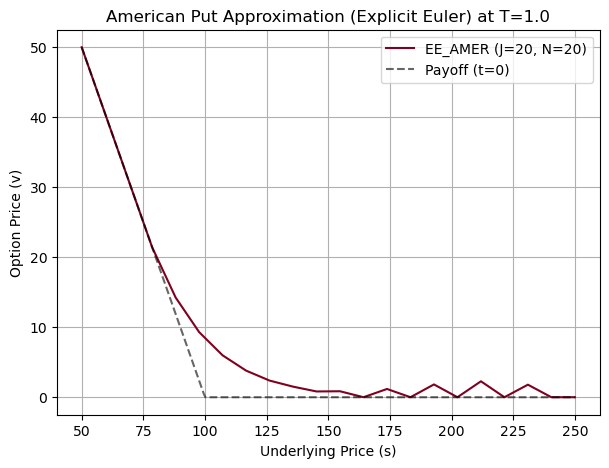

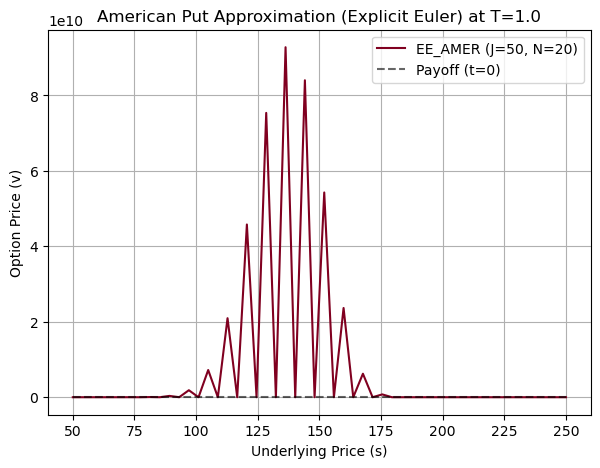

In [2]:
import matplotlib.pyplot as plt

def plot_scheme_curves(scheme, J_list, N, payoff_func=phi, title=None, color="#800020", n_plot=300):

    s_plot = np.linspace(Smin, Smax, n_plot)

    for J in J_list:
        s_grid, U_grid = solve_EDP(N, J, scheme=scheme)

        plt.figure(figsize=(7, 5))
        plt.plot(s_grid, U_grid, label=f"{scheme} (J={J}, N={N})", color=color)
        plt.plot(s_plot, payoff_func(s_plot), "k--", label="Payoff (t=0)", alpha=0.6)

        if title is None:
            plt.title(f"American Put Approximation with {scheme} Scheme")
        else:
            plt.title(title)

        plt.xlabel("Underlying Price (s)")
        plt.ylabel("Option Price (v)")
        plt.grid(True)
        plt.legend()
        plt.show()

J_list = [20, 50]
N = 20

plot_scheme_curves("EE_AMER", J_list, N,title=f"American Put Approximation (Explicit Euler) at T={T}")

We observe that the explicit Euler scheme provides a numerically stable solution for the parameters $J = 20$ and $N = 20$. The resulting curve remains smooth and close to the expected behavior of the option price.

However, when the number of spatial grid points is increased ($J = 50$) while keeping the same time step ($N = 20$), the scheme becomes unstable and produces strong oscillations as well as numerically aberrant values.

This behavior is consistent with the restrictive stability condition of the explicit scheme, which imposes a constraint linking the temporal and spatial discretization steps.

## Scheme Order and Approximation of $v$

In [3]:
def interp_value(s, U_full, x):
    # Flatten arrays to ensure 1D structure
    s = s.reshape(-1)
    u = U_full.reshape(-1)

    # Extrapolation at boundaries
    if x <= s[0]:
        return float(u[0])
    if x >= s[-1]:
        return float(u[-1])

    # Locate interval containing x
    j = np.searchsorted(s, x) - 1

    # Linear interpolation weight
    w = (x - s[j]) / (s[j+1] - s[j])

    # Return interpolated value
    return float((1 - w) * u[j] + w * u[j+1])


Sval = 90.0  # Evaluation point S_val

# Spatial refinements
I_list = [19, 39, 79, 159, 319]

prev_v = None
prev_err = None
prev_dt = 0

for I in I_list:

    # Time step chosen according to refinement rule
    N = int(2 * (I + 1)**2 / 10)
    dt = T / N

    # Measure CPU time
    t0 = time.perf_counter()
    s, U = solve_EDP(N=N, J=I, scheme="EE_AMER", payoff=1)
    tcpu = time.perf_counter() - t0

    # Interpolated value at Sval
    vbar = interp_value(s, U, Sval)

    # Error and empirical order computation
    if prev_v is None:
        err = 0.0
        order = 0.0
    else:
        err = abs(vbar - prev_v)

        if (prev_err is None) or (prev_err == 0.0) or (err == 0.0):
            order = 0.0
        else:
            order = np.log(prev_err / err) / np.log(prev_dt / dt)

    prev_dt = dt

    print(f"I={I:4d}, N={N:6d}, v:={vbar: .6f}, err={err: .6f}, ord={order: .2f} [tcpu={tcpu: .3f}]")

    prev_v = vbar
    prev_err = err

I=  19, N=    80, v:= 12.947098, err= 0.000000, ord= 0.00 [tcpu= 0.001]
I=  39, N=   320, v:= 13.064717, err= 0.117619, ord= 0.00 [tcpu= 0.003]
I=  79, N=  1280, v:= 13.109572, err= 0.044855, ord= 0.70 [tcpu= 0.011]
I= 159, N=  5120, v:= 13.117805, err= 0.008233, ord= 1.22 [tcpu= 0.095]
I= 319, N= 20480, v:= 13.119987, err= 0.002183, ord= 0.96 [tcpu= 0.462]


The approximations obtained for $\bar{v} = v(T, S_{\text{val}})$ converge toward a limiting value close to 13.12, in agreement with the typical reference results.  

The error $\mathrm{err} = |v_k - v_{k-1}|$ decreases as the mesh is refined, confirming both the stability and the convergence of the scheme in this discretization regime.

### Implicit Scheme via Splitting

For stability reasons, implicit schemes are considered.  
The first scheme studied is an implicit splitting method, which consists of first solving a linear European-type problem, and then enforcing the obstacle constraint by projection onto the payoff $g$.

#### EI–AMER–SPLIT Scheme

The scheme is defined as follows:

$$
\text{(i)} \quad
\frac{U^{n+1,(1)} - U^n}{\Delta t}
+ A U^{n+1,(1)} + q(t_{n+1}) = 0,
$$

$$
\text{(ii)} \quad
U^{n+1} = \max\left(U^{n+1,(1)}, g\right).
$$

The scheme is unconditionally stable (no CFL condition), since step (i) is implicit.  
Step (ii) enforces the early exercise constraint pointwise.

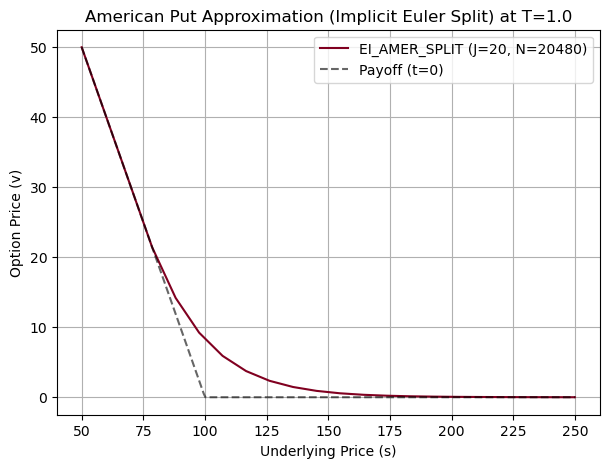

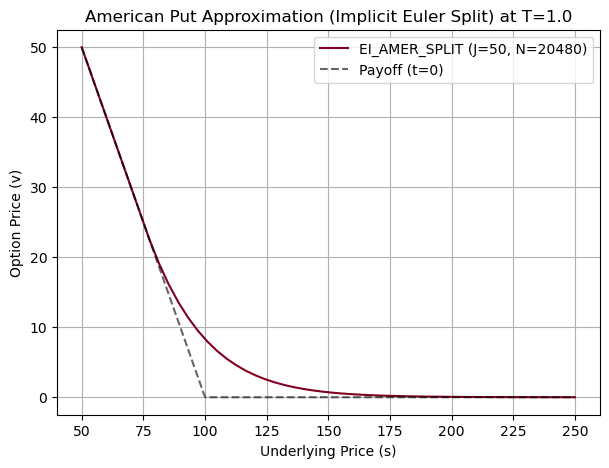

In [4]:
plot_scheme_curves("EI_AMER_SPLIT", J_list, N,title=f"American Put Approximation (Implicit Euler Split) at T={T}")

### Crank–Nicolson Variant: CN–AMER–SPLIT

A Crank–Nicolson-type variant consists in replacing step (i) with a trapezoidal discretization:

$$
\frac{U^{n+1,(1)} - U^n}{\Delta t}
+ \frac{1}{2} \left( A U^{n+1,(1)} + q(t_{n+1}) \right)
+ \frac{1}{2} \left( A U^n + q(t_n) \right)
= 0,
$$

and then projecting as before:

$$
U^{n+1} = \max\left(U^{n+1,(1)}, g\right).
$$

Although the linear part is second-order accurate in time for a smooth problem, the projection step (obstacle constraint) may degrade the observed global order of convergence.

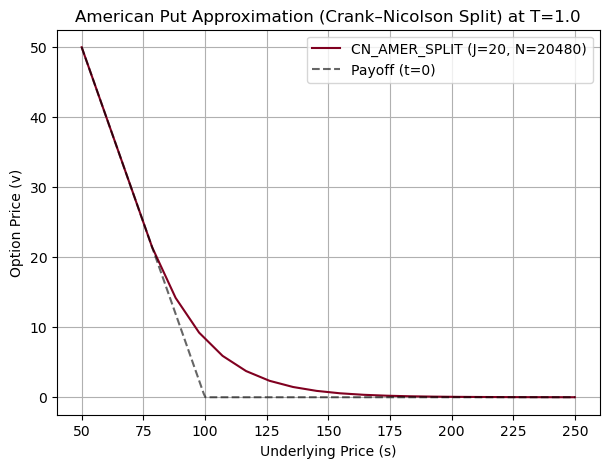

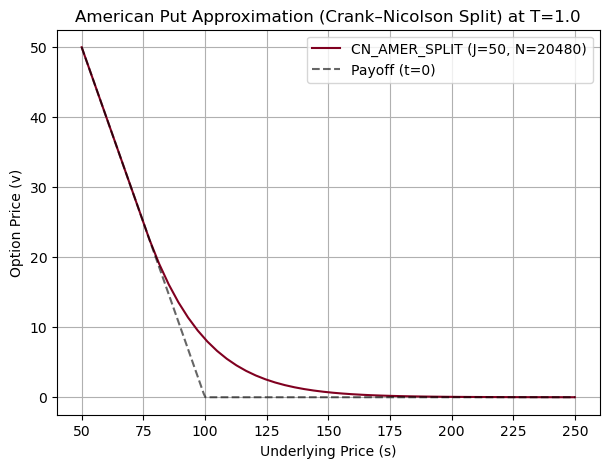

In [5]:
plot_scheme_curves("CN_AMER_SPLIT", J_list, N,title=f"American Put Approximation (Crank–Nicolson Split) at T={T}")

### Convergence Tables (Payoff $\varphi_1$)

We compute

$$
\bar{v} \approx v(T, S_{\text{val}}),
\qquad T = 1,
\qquad S_{\text{val}} = 90,
$$

using linear interpolation when $S_{\text{val}}$ does not coincide with a grid node.  
Following the prescribed refinement strategy, we choose the pairs

$$
(J + 1, N) = (20, 20) \cdot 2^k,
\qquad k = 0, 1, 2, 3, 4, 5.
$$

The error is estimated by successive differences

$$
\mathrm{err}_k = \left| \bar{v}_k - \bar{v}_{k-1} \right|,
$$

and the empirical order (in time) is computed as

$$
\beta_k =
\frac{\log(\mathrm{err}_{k-1} / \mathrm{err}_k)}
{\log(\Delta t_{k-1} / \Delta t_k)},
\qquad
\Delta t_k = \frac{T}{N_k}.
$$

In [6]:
def convergence_table(scheme, payoff=1, kmax=6, Sval=90.0):
    print(f"\n=== Convergence table: scheme={scheme}, payoff={payoff} ===")

    prev_v = None
    prev_err = None
    prev_dt = None

    for k in range(kmax):
        I1 = 20 * (2**k)
        N = 20 * (2**k)
        J = I1 - 1

        dt = T / N

        t0 = time.perf_counter()
        s, U = solve_EDP(N=N, J=J, scheme=scheme, payoff=payoff)
        tcpu = time.perf_counter() - t0

        vbar = interp_value(s, U, Sval)

        if prev_v is None:
            err = 0.0
            beta = 0.0
        else:
            err = abs(vbar - prev_v)
            if (prev_err is None) or (prev_err == 0.0) or (err == 0.0):
                beta = 0.0
            else:
                # beta_k = log(e_{k-1}/e_k)/log(dt_{k-1}/dt_k)
                beta = np.log(prev_err/err) / np.log(prev_dt/dt)

        print(f"(I+1,N)=({I1:4d},{N:6d})  v={vbar:.6f}  err={err:.6e}  order={beta:.2f}  [tcpu={tcpu:.3f}]")

        prev_v = vbar
        prev_err = err
        prev_dt = dt


# ---- Tables required by the statement ----
convergence_table("EI_AMER_SPLIT", payoff=1, kmax=6, Sval=90.0)
convergence_table("CN_AMER_SPLIT", payoff=1, kmax=6, Sval=90.0)



=== Convergence table: scheme=EI_AMER_SPLIT, payoff=1 ===
(I+1,N)=(  20,    20)  v=12.771151  err=0.000000e+00  order=0.00  [tcpu=0.001]
(I+1,N)=(  40,    40)  v=12.958929  err=1.877781e-01  order=0.00  [tcpu=0.002]
(I+1,N)=(  80,    80)  v=13.054834  err=9.590411e-02  order=0.97  [tcpu=0.006]
(I+1,N)=( 160,   160)  v=13.089790  err=3.495654e-02  order=1.46  [tcpu=0.039]
(I+1,N)=( 320,   320)  v=13.105599  err=1.580906e-02  order=1.14  [tcpu=0.218]
(I+1,N)=( 640,   640)  v=13.113227  err=7.627800e-03  order=1.05  [tcpu=2.689]

=== Convergence table: scheme=CN_AMER_SPLIT, payoff=1 ===
(I+1,N)=(  20,    20)  v=12.888852  err=0.000000e+00  order=0.00  [tcpu=0.001]
(I+1,N)=(  40,    40)  v=13.021900  err=1.330487e-01  order=0.00  [tcpu=0.003]
(I+1,N)=(  80,    80)  v=13.090984  err=6.908413e-02  order=0.95  [tcpu=0.008]
(I+1,N)=( 160,   160)  v=13.107807  err=1.682262e-02  order=2.04  [tcpu=0.030]
(I+1,N)=( 320,   320)  v=13.114979  err=7.172214e-03  order=1.23  [tcpu=0.186]
(I+1,N)=( 640

The numerical results show a decrease of the error as the mesh is refined, and convergence toward a limiting value close to $\bar{v} \approx 13.12$.

For EI–AMER–SPLIT, the observed order stabilizes around 1 for fine refinements, which is consistent with an implicit Euler-type scheme.

For CN–AMER–SPLIT, the order is not uniformly equal to 2: although a local order close to 2 may appear at some refinement levels, the finest refinements yield an effective order close to 1.3.

This is consistent with the theoretical remark that the projection step  
$U^{n+1} = \max\left(U^{n+1,(1)}, g\right)$ (obstacle problem) degrades the temporal order of the Crank–Nicolson scheme for the nonlinear PDE.

### Implicit Euler Scheme

We consider the implicit Euler time discretization for the obstacle problem associated with the American option:

$$
\min\!\left( \frac{U^{n+1}-U^n}{\Delta t} + A U^{n+1} + q(t_{n+1}),\; U^{n+1}-g \right)=0,
\qquad n=0,\ldots,N-1,
\qquad U^0=g.
$$

Setting

$$
B := I_d + \Delta t\,A,
\qquad
b := U^n - \Delta t\, q(t_{n+1}),
$$

the computation of $U^{n+1}$ amounts, at each time step, to solving the linear complementarity problem

$$
\min(Bx-b,\; x-g)=0
\quad \text{in } \mathbb{R}^I,
\qquad \text{then } U^{n+1}=x.
$$

---

### PSOR Algorithm

To solve the previous complementarity problem, we use the PSOR (Projected Successive Over-Relaxation) algorithm.

Writing $B=L+U$, where $L$ is the lower triangular part of $B$ (including the diagonal) and $U$ is the strictly upper triangular part, the PSOR iteration reads componentwise:

$$
x_i^{k+1}
=
\max\!\left(x_i^k+\omega\big(x_{i,\mathrm{GS}}^{k+1}-x_i^k\big),\; g_i\right),
\qquad
x_{i,\mathrm{GS}}^{k+1}
=
\frac{b_i-\sum_{j\ne i} B_{ij}x_j}{B_{ii}}.
$$

Here $\omega\in(1,2)$ is the over-relaxation parameter. 

---

### Integration into the IE–AMER–PSOR Scheme

At each time step, we construct $B=I+\Delta t\,A$ and $b=U^n-\Delta t\,q(t_{n+1})$, and then solve the complementarity problem using PSOR in order to obtain $U^{n+1}$. This approach corresponds to the scheme denoted **IE_AMER_PSOR** in our implementation.

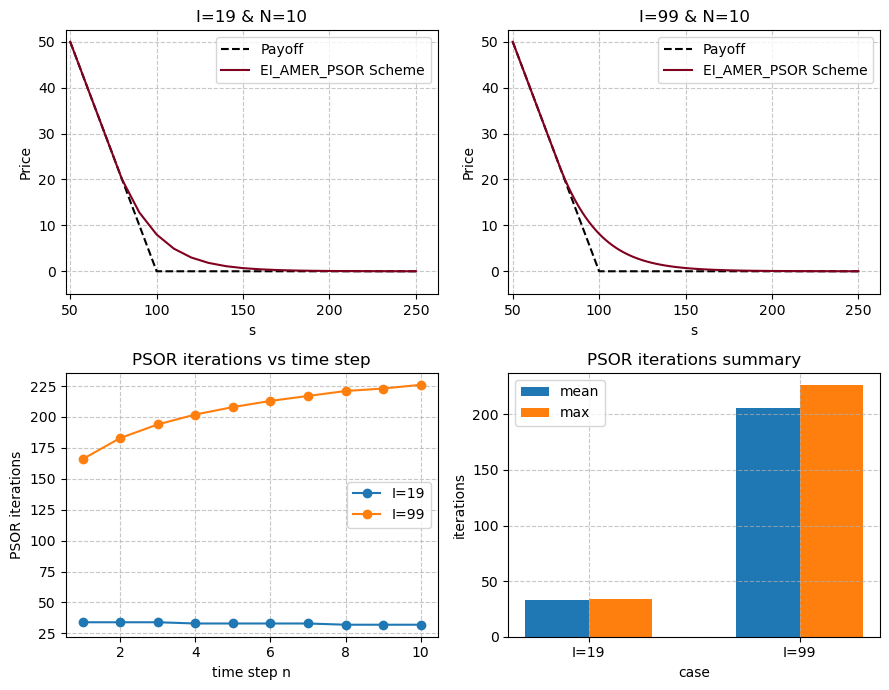

I=19, iters=[34, 34, 34, 33, 33, 33, 33, 32, 32, 32], mean=33.0, max=34
I=99, iters=[166, 183, 194, 202, 208, 213, 217, 221, 223, 226], mean=205.3, max=226


In [7]:

scheme = 'EI_AMER_PSOR'
N = 10
I_values = np.array([19, 99])   # here I is J (interior points). I+1=21 and 100.

dico_time_elapsed_1 = {}
dico_nb_psor_iterations_1 = {}

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for idx, I in enumerate(I_values):

    s, U_full, iters_time = solve_EDP(N=N, J=I, scheme=scheme, payoff=1,
                                      eta=1e-10, kmax=20000, verbose=False, w=1.5)


    dico_nb_psor_iterations_1[idx] = np.asarray(iters_time).reshape(-1)

    # ---- subplot 0/1: price curve ----
    ax = axes[idx]
    ax.set_title(f'I={I} & N={N}')
    ax.plot(s, phi(s, payoff=1), label='Payoff', linestyle='--', color='k')
    ax.plot(s, U_full.reshape(-1), label=f'{scheme} Scheme', color="#800020")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel("s")
    ax.set_ylabel("Price")
    ax.set_ylim(-5, K * 1.05 / 2)
    ax.set_xlim(Smin*0.95, Smax*1.05)

# ---- subplot 2: iterations per time step ----
ax = axes[2]
ax.set_title("PSOR iterations vs time step")
ax.set_xlabel("time step n")
ax.set_ylabel("PSOR iterations")
ax.grid(True, linestyle='--', alpha=0.7)
for idx, I in enumerate(I_values):
    it = dico_nb_psor_iterations_1[idx]
    ax.plot(np.arange(1, len(it)+1), it, marker='o', label=f"I={I}")
ax.legend()

# ---- subplot 3: summary (mean/max) ----
ax = axes[3]
ax.set_title("PSOR iterations summary")
ax.set_xlabel("case")
ax.set_ylabel("iterations")
ax.grid(True, linestyle='--', alpha=0.7)

means = [dico_nb_psor_iterations_1[i].mean() for i in range(len(I_values))]
maxs  = [dico_nb_psor_iterations_1[i].max()  for i in range(len(I_values))]

x = np.arange(len(I_values))
ax.bar(x - 0.15, means, width=0.3, label="mean")
ax.bar(x + 0.15, maxs,  width=0.3, label="max")
ax.set_xticks(x)
ax.set_xticklabels([f"I={I}" for I in I_values])
ax.legend()

plt.tight_layout()
plt.show()

# print numerical evidence
for idx, I in enumerate(I_values):
    it = dico_nb_psor_iterations_1[idx]
    print(f"I={I}, iters={it.tolist()}, mean={it.mean():.1f}, max={it.max()}")


#### Slowdown When the Spatial Grid is Refined

We observe numerically that the computational cost of PSOR increases as $I$ grows. 

In particular, for $\sigma = 0.3$, $N = 10$, and $I+1 = 100$, the number of PSOR iterations required for convergence increases over the time steps. Moreover, the average number of iterations is significantly higher than for a coarser grid (for example $I+1 = 20$).

This slowdown is consistent with the deterioration of the conditioning of the matrix $B$ as the spatial step size $h$ decreases.

In [8]:
scheme = 'EI_AMER_PSOR'
N = 20
I_values = np.array([19, 99])

dico_nb_psor_iterations_1 = {}   # w=1
dico_nb_psor_iterations = {}     # w=1.5

for idx, I in enumerate(I_values):

    # w = 1
    s, U, iters = solve_EDP(N=N, J=I,  payoff=1,verbose=True, scheme=scheme, w=1.0)
    dico_nb_psor_iterations_1[idx] = iters

Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.05 seconds
Elapsed time: 0.06 seconds
Elapsed time: 0.09 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.07 seconds
Elapsed time: 0.08 seconds
Elapsed time: 0.08 seconds
Elapsed time: 0.08 seconds
Elapsed time: 0.08 seconds
Elapsed time: 0.08 seconds
Elapsed time: 0.09 seconds
Elapsed time: 0.09 seconds
E

In [9]:
for idx, I in enumerate(I_values):

    # w = 1.5
    s, U, iters = solve_EDP(N=N, J=I,  payoff=1,verbose=True, scheme=scheme, w=1.5)
    dico_nb_psor_iterations[idx] = iters


Elapsed time: 0.00 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.01 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.00 seconds
Elapsed time: 0.02 seconds
Elapsed time: 0.02 seconds
Elapsed time: 0.02 seconds
Elapsed time: 0.02 seconds
Elapsed time: 0.02 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
Elapsed time: 0.03 seconds
E

#### Acceleration by Over-Relaxation

We also tested the effect of over-relaxation with $\omega > 1$. 

Numerically, choosing $\omega \in (1,2)$ (for example $\omega = 1.5$) reduces the number of iterations required for convergence, thereby decreasing the total computation time.

The curves representing the "number of PSOR iterations per time step" confirm that, for fixed $I$, $\omega = 1.5$ leads to faster convergence than $\omega = 1$.

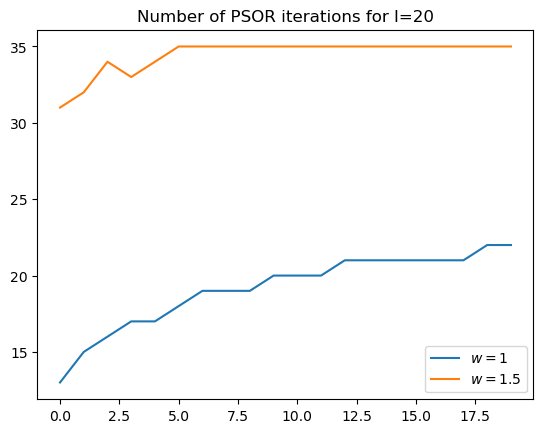

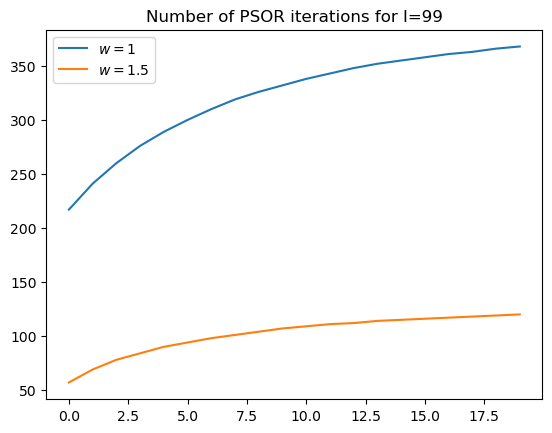

In [10]:
plt.figure()
plt.plot(dico_nb_psor_iterations_1[0], label=r'$w=1$')
plt.plot(dico_nb_psor_iterations[0], label=r'$w=1.5$')
plt.legend()
plt.title('Number of PSOR iterations for I=20')

plt.figure()
plt.plot(dico_nb_psor_iterations_1[1], label=r'$w=1$')
plt.plot(dico_nb_psor_iterations[1], label=r'$w=1.5$')
plt.legend()
plt.title('Number of PSOR iterations for I=99')
plt.show()

We observe a clear benefit in using the accelerated method with $\omega = 1.5$ for large values of $I$, as the graph below clearly shows that the number of iterations of the PSOR algorithm is significantly lower. 

This results in a substantial reduction in execution time.

### Test with a Discontinuous Payoff $\varphi_2$

The IE–AMER–PSOR scheme was also tested using the discontinuous payoff $\varphi_2$.

The numerical solution remains stable. However, the discontinuity in the initial condition makes the solution profiles more challenging to approximate on coarse spatial grids. In practice, this typically requires a finer spatial discretization to obtain a sharper and more accurate representation of the transition region.

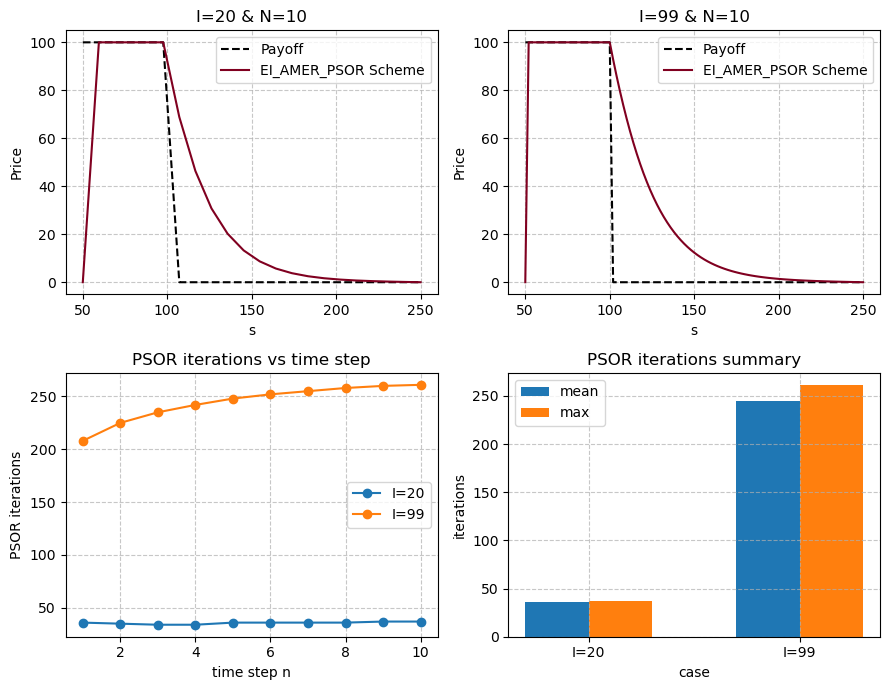

I=20, iters=[36, 35, 34, 34, 36, 36, 36, 36, 37, 37], mean=35.7, max=37
I=99, iters=[208, 225, 235, 242, 248, 252, 255, 258, 260, 261], mean=244.4, max=261


In [11]:


scheme = 'EI_AMER_PSOR'
N = 10
I_values = np.array([20, 99])

dico_time_elapsed_1 = {}
dico_nb_psor_iterations_1 = {}

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for idx, I in enumerate(I_values):

    s, U_full, iters_time = solve_EDP(N=N, J=I, scheme=scheme, payoff=2,
                                      eta=1e-10, kmax=20000, verbose=False, w=1.5)


    dico_nb_psor_iterations_1[idx] = np.asarray(iters_time).reshape(-1)

    # ---- subplot 0/1: price curve ----
    ax = axes[idx]
    ax.set_title(f'I={I} & N={N}')
    ax.plot(s, phi(s, payoff=2), label='Payoff', linestyle='--', color='k')
    ax.plot(s, U_full.reshape(-1), label=f'{scheme} Scheme', color="#800020")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xlabel("s")
    ax.set_ylabel("Price")


# ---- subplot 2: iterations per time step ----
ax = axes[2]
ax.set_title("PSOR iterations vs time step")
ax.set_xlabel("time step n")
ax.set_ylabel("PSOR iterations")
ax.grid(True, linestyle='--', alpha=0.7)
for idx, I in enumerate(I_values):
    it = dico_nb_psor_iterations_1[idx]
    ax.plot(np.arange(1, len(it)+1), it, marker='o', label=f"I={I}")
ax.legend()

# ---- subplot 3: summary (mean/max) ----
ax = axes[3]
ax.set_title("PSOR iterations summary")
ax.set_xlabel("case")
ax.set_ylabel("iterations")
ax.grid(True, linestyle='--', alpha=0.7)

means = [dico_nb_psor_iterations_1[i].mean() for i in range(len(I_values))]
maxs  = [dico_nb_psor_iterations_1[i].max()  for i in range(len(I_values))]

x = np.arange(len(I_values))
ax.bar(x - 0.15, means, width=0.3, label="mean")
ax.bar(x + 0.15, maxs,  width=0.3, label="max")
ax.set_xticks(x)
ax.set_xticklabels([f"I={I}" for I in I_values])
ax.legend()

plt.tight_layout()
plt.show()

# print numerical evidence
for idx, I in enumerate(I_values):
    it = dico_nb_psor_iterations_1[idx]
    print(f"I={I}, iters={it.tolist()}, mean={it.mean():.1f}, max={it.max()}")


### Semi-Smooth Newton Method

An alternative approach to solving the linear complementarity problem

$$
\min(Bx - b,\; x - g) = 0
$$

is to use a semi-smooth Newton method.

We define the nonlinear function

$$
F(x) = \min(Bx - b,\; x - g),
$$

and seek a solution of $F(x) = 0$ using a generalized Newton iteration:

$$
x^{k+1} = x^k - \left(F'(x^k)\right)^{-1} F(x^k).
$$

The generalized Jacobian $F'(x^k)$ is constructed row by row as follows:

$$
F'(x^k)_{i,j} =
\begin{cases}
B_{i,j}, & \text{if } (Bx^k - b)_i \le (x^k - g)_i, \\
\delta_{i,j}, & \text{otherwise},
\end{cases}
$$

where $\delta_{i,j}$ denotes the Kronecker delta.

In the numerical implementation, this method is used at each time step to solve the implicit problem arising in the schemes **IE_AMER_NEWTON** and **CN_AMER_NEWTON**.

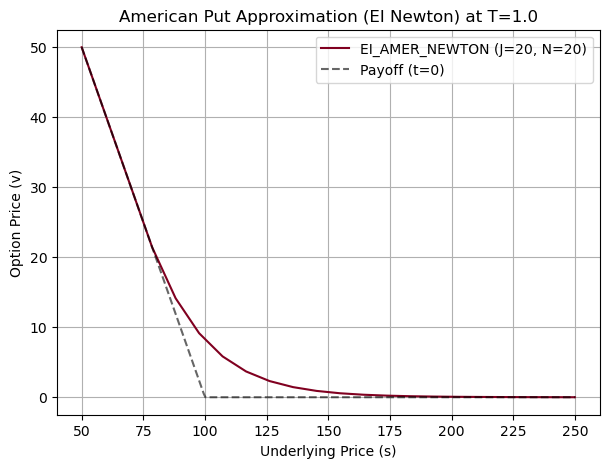

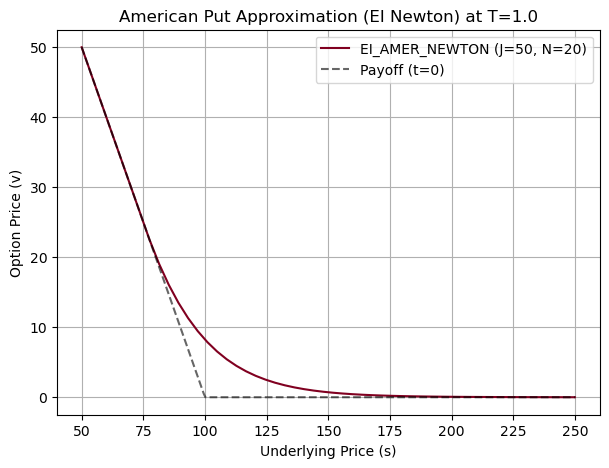

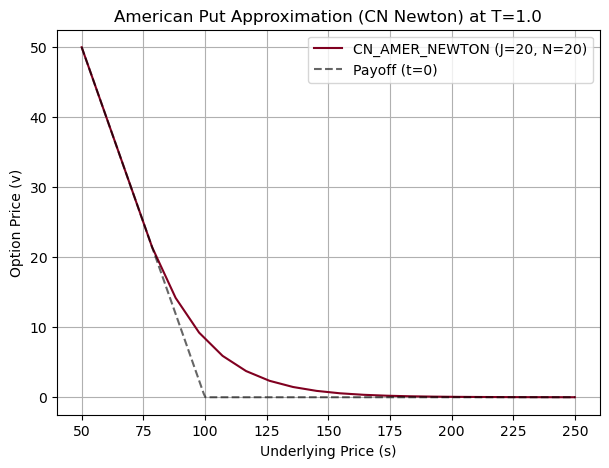

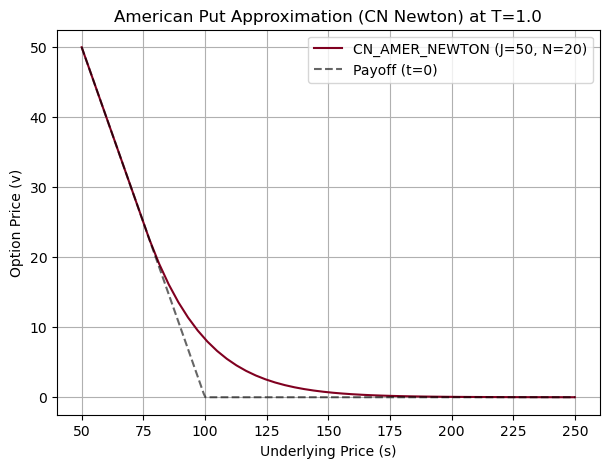

In [12]:
plot_scheme_curves("EI_AMER_NEWTON", J_list, 20, title=f"American Put Approximation (EI Newton) at T={T}")
plot_scheme_curves("CN_AMER_NEWTON", J_list, 20, title=f"American Put Approximation (CN Newton) at T={T}")

##  Higher-Order Schemes

### BDF Scheme

To obtain a second-order time discretization, we consider the BDF (Backward Differentiation Formula) scheme.

After initialization with

$$
U^0 = g, 
\qquad
U^1 \text{ computed using the implicit Euler scheme},
$$

the method is defined, for $n = 1, \ldots, N-1$, by the obstacle problem

$$
\min\!\left(
\frac{3U^{n+1} - 4U^n + U^{n-1}}{2\Delta t}
+ A U^{n+1}
+ q(t_{n+1}),
\;
U^{n+1} - g
\right) = 0.
$$

Introducing

$$
\tilde{B} = 3I + 2\Delta t\, A,
\qquad
\tilde{b} = 4U^n - U^{n-1} - 2\Delta t\, q(t_{n+1}),
$$

the computation of $U^{n+1}$ reduces, at each time step, to solving the linear complementarity problem

$$
\min(\tilde{B}x - \tilde{b},\; x - g) = 0,
$$

which we solve using the semi-smooth Newton method.

In [13]:
def error_tables_for_scheme_set(payoff, ruleN, Iplus1_list, schemes):
    for scheme in schemes:
        print(f"\n=== scheme={scheme}, payoff={payoff} ===")
        prev_v = None
        prev_err = None
        prev_dt = None

        for Iplus1 in Iplus1_list:
            J = Iplus1 - 1
            N = int(ruleN(J))
            if N < 2 and scheme == "BDF2_NEWTON":
                N = 2  # BDF2 needs at least 2 steps

            dt = T / N

            t0 = time.perf_counter()
            s, U = solve_EDP(N=N, J=J, scheme=scheme, payoff=payoff, eta=1e-10, kmax=20000, verbose=False, w=1.0)
            tcpu = time.perf_counter() - t0

            vbar = interp_value(s, U, Sval)

            if prev_v is None:
                err = 0.0
                order = 0.0
            else:
                err = abs(vbar - prev_v)
                if (prev_err is None) or (prev_err == 0.0) or (err == 0.0):
                    order = 0.0
                else:
                    order = np.log(prev_err/err) / np.log(prev_dt/dt)

            print(f"I+1={Iplus1:4d}, N={N:6d}, v={vbar:.6f}, err={err:.3e}, ord={order:.2f} [tcpu={tcpu:.3f}]")

            prev_v = vbar
            prev_err = err
            prev_dt = dt


In [14]:
Sval = 90.0
Iplus1_list = [20, 40, 80, 160, 320]

schemes_compare = ["BDF_NEWTON"]

# N = I
error_tables_for_scheme_set(payoff=1, ruleN=lambda I: I, Iplus1_list=Iplus1_list, schemes=schemes_compare)

# N = I/10
error_tables_for_scheme_set(payoff=1, ruleN=lambda I: max(1, I//10), Iplus1_list=Iplus1_list, schemes=schemes_compare)



=== scheme=BDF_NEWTON, payoff=1 ===
I+1=  20, N=    19, v=12.927790, err=0.000e+00, ord=0.00 [tcpu=0.004]
I+1=  40, N=    39, v=13.058698, err=1.309e-01, ord=0.00 [tcpu=0.006]
I+1=  80, N=    79, v=13.107543, err=4.884e-02, ord=1.40 [tcpu=0.014]
I+1= 160, N=   159, v=13.117039, err=9.496e-03, ord=2.34 [tcpu=0.059]
I+1= 320, N=   319, v=13.119699, err=2.660e-03, ord=1.83 [tcpu=0.415]

=== scheme=BDF_NEWTON, payoff=1 ===
I+1=  20, N=     1, v=12.118641, err=0.000e+00, ord=0.00 [tcpu=0.000]
I+1=  40, N=     3, v=12.903028, err=7.844e-01, ord=0.00 [tcpu=0.001]
I+1=  80, N=     7, v=13.086605, err=1.836e-01, ord=1.71 [tcpu=0.003]
I+1= 160, N=    15, v=13.109835, err=2.323e-02, ord=2.71 [tcpu=0.011]
I+1= 320, N=    31, v=13.116615, err=6.780e-03, ord=1.70 [tcpu=0.080]


In [15]:
Sval = 150.0
Iplus1_list = [20, 40, 80, 160, 320]

error_tables_for_scheme_set(payoff=2, ruleN=lambda I: I, Iplus1_list=Iplus1_list, schemes=schemes_compare)
error_tables_for_scheme_set(payoff=2, ruleN=lambda I: max(1, I//10), Iplus1_list=Iplus1_list, schemes=schemes_compare)



=== scheme=BDF_NEWTON, payoff=2 ===
I+1=  20, N=    19, v=13.017144, err=0.000e+00, ord=0.00 [tcpu=0.004]
I+1=  40, N=    39, v=12.864179, err=1.530e-01, ord=0.00 [tcpu=0.006]
I+1=  80, N=    79, v=12.825866, err=3.831e-02, ord=1.96 [tcpu=0.013]
I+1= 160, N=   159, v=12.816265, err=9.601e-03, ord=1.98 [tcpu=0.053]
I+1= 320, N=   319, v=12.813860, err=2.404e-03, ord=1.99 [tcpu=0.355]

=== scheme=BDF_NEWTON, payoff=2 ===
I+1=  20, N=     1, v=10.516810, err=0.000e+00, ord=0.00 [tcpu=0.000]
I+1=  40, N=     3, v=11.885537, err=1.369e+00, ord=0.00 [tcpu=0.000]
I+1=  80, N=     7, v=12.608953, err=7.234e-01, ord=0.75 [tcpu=0.001]
I+1= 160, N=    15, v=12.780153, err=1.712e-01, ord=1.89 [tcpu=0.006]
I+1= 320, N=    31, v=12.806064, err=2.591e-02, ord=2.60 [tcpu=0.036]


For the payoff $\varphi_1$, the BDF–Newton scheme converges towards $\bar{v} \approx 13.12$, with an observed order of convergence close to 2 on fine grids. This is consistent with a second-order time discretization when the solution is sufficiently regular.

The CPU cost increases with mesh refinement but remains moderate thanks to the efficiency of the Newton solver.

For the discontinuous payoff $\varphi_2$, convergence becomes less regular when the time step is coarse ($N \approx I/10$). However, in the regime $N \approx I$, we again observe an order close to 2 and stabilization towards $\bar{v} \approx 12.814$.

Overall, BDF–Newton provides improved accuracy compared to the implicit Euler scheme, for a comparable computational cost.